<a href="https://colab.research.google.com/github/AlCatt91/Europe-Geoguesser/blob/main/Geoguesser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A geo-guesser model for Europe

##Introduction

In this notebook we address the problem of geolocating a landscape picture using computer vision Deep Learning algorithms. The task is framed as a classification problem: given a picture from a European country we aim to identify the correct region of provenance (the country where it was taken, or the specific cell in a finer grid). We then use the final model to also make inference on the exact latitude/longitude coordinates of the location.

We test several different neural networks based on the ResNet50 architecture, which we train (with transfer learning) on a custom dataset of 50000+ Street Views panoramas constructed with the Google Maps API. We show how it is possible to improve on a single-image model by integrating the information coming from different views taken at the same location.   


0. [Packages](#0)

1. [Setup: geographical framework](#1)

2. [Data scraping](#2)

3. [Grid classification](#3)

  3.1 [Coordinates inference](#3.1)

4. [Country prediction](#4)

##0. Packages <a name=0></a>

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from typing import List
import requests
import re

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

! [ -e /content ] && pip install -Uqq fastai 
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

import streetview_scraping_tools
from coordinates_tools import *

## 1. Setup: geographical framework <a name=1></a>

[Natural Earth](https://www.naturalearthdata.com/downloads/) provides many detailed map datasets for all countries in the world. We can quickly retrieve the polygonal latitude/longitude coordinates for countries and their borders, as contained in the [Admin 0 – Countries](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) dataset, by using geopandas. 

Archive:  countries.zip
  inflating: ne_10m_admin_0_countries.README.html  
 extracting: ne_10m_admin_0_countries.VERSION.txt  
 extracting: ne_10m_admin_0_countries.cpg  
  inflating: ne_10m_admin_0_countries.dbf  
  inflating: ne_10m_admin_0_countries.prj  
  inflating: ne_10m_admin_0_countries.shp  
  inflating: ne_10m_admin_0_countries.shx  


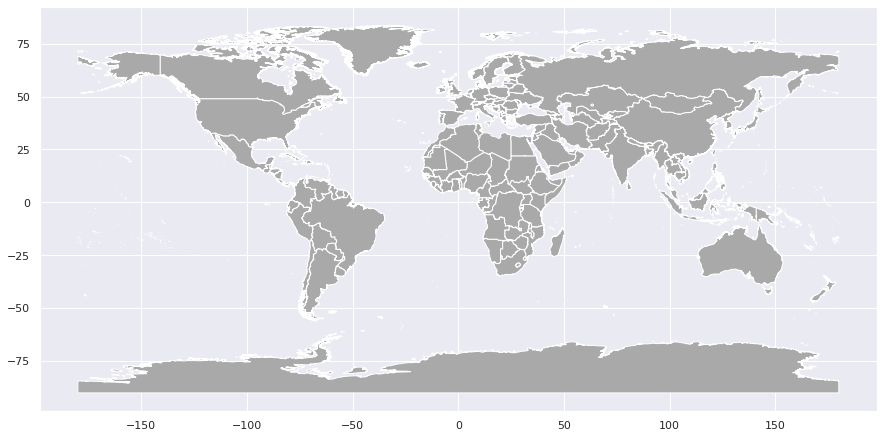

In [12]:
!wget -q -O countries.zip https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
!unzip countries.zip

world = gpd.read_file("ne_10m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(15, 8))
world.plot(color='darkgrey', ax=ax)

We choose to focus on a rectangular region (which spans 36 degrees in latitude and 46 degrees in longitude) encompassing most countries in continental Europe and their islands, Ireland and the UK, parts of Turkey and western Russia. Let us look at exactly which countries are contained in this region, and how much of their respective total extension we are considering.

In [19]:
def find_inter_area(row: pd.Series, long_min: float, long_max: float, lat_min: float, lat_max: float) -> (MultiPolygon, float):
  """ 
  Finds the intersection of row['geometry'] with the rectangular region inside long_min, long_max, lat_min, lat_max.
  Returns the intersection as MultiPolygon and the fraction of the area of row['geometry'] inside the rectangle.
  """

  zone = Polygon([(long_min, lat_min), (long_max, lat_min), (long_max, lat_max), (long_min, lat_max)])
  overl = []
  if isinstance(row['geometry'], MultiPolygon):
    for pol in row['geometry']:
      inters = pol.intersection(zone)
      if not inters.is_empty:
        if isinstance(inters, MultiPolygon):
          for p in inters:
            overl.append(p)
        else:
          overl.append(inters)
  else:
    inters = row['geometry'].intersection(zone)
    if not inters.is_empty:
      if isinstance(inters, MultiPolygon):
        for p in inters:
            overl.append(p)
      else:
        overl.append(inters)

  mpol = MultiPolygon(overl)
  perc = mpol.area / row['geometry'].area
  return mpol, perc

In [20]:
long_min = -10.6
long_max = 36.36
lat_min = 35.4
lat_max = 72.0

inters = world.apply(partial(find_inter_area, long_min=long_min, long_max=long_max, lat_min=lat_min, lat_max=lat_max), axis=1, result_type='expand')
#Consider only countries having non-empty intersection with the region of interest
valid_inters = world.loc[inters[1] > 0.0, ['NAME']].join(inters)
valid_inters.rename(columns={'NAME':'country', 0:'geometry', 1:'% area'}, inplace=True)
valid_inters[['country', '% area']].sort_values('% area')

,country,% area
27,Morocco,0.006014
20,Syria,0.014997
48,Russia,0.040720
121,Algeria,0.054257
167,N. Cyprus,0.158745
73,Tunisia,0.269440
66,Turkey,0.591904
53,Norway,0.698660
34,Ukraine,0.864512
22,France,0.898517


We discard countries having less than 30% of their area inside the region of interest we are considering (except for Russia, which we keep). From this list, we then drop countries with insufficient Google Street View coverage (such as Moldova and Belarus). Finally, we merge dependecies and provinces, like Jersey, to their motherlands. We are left with the following 39 countries (marked in blue in the map below):

In [ ]:
russia = valid_inters.loc[valid_inters['country'] == 'Russia']
final_inters = pd.concat([valid_inters.loc[valid_inters['% area'] > 0.3], russia]).sort_index()
final_inters.at[55, 'geometry'] = MultiPolygon([*valid_inters.loc[55, 'geometry'], *valid_inters.loc[223, 'geometry']])
final_inters.at[79, 'geometry'] = MultiPolygon([*valid_inters.loc[79, 'geometry'], *valid_inters.loc[220, 'geometry'], *valid_inters.loc[221, 'geometry'], *valid_inters.loc[222, 'geometry']])
final_inters.drop([35, 65, 95, 131, 140, 152, 166, 220, 221, 222, 223, 224], inplace=True)
final_inters.country

22             France
34            Ukraine
44          Lithuania
48             Russia
49            Czechia
50            Germany
51            Estonia
52             Latvia
53             Norway
54             Sweden
55            Finland
58         Luxembourg
60            Belgium
62          Macedonia
63            Albania
66             Turkey
67              Spain
71            Denmark
74            Romania
75            Hungary
76           Slovakia
77             Poland
78            Ireland
79     United Kingdom
80             Greece
89            Austria
91              Italy
92        Switzerland
94        Netherlands
97             Serbia
103           Croatia
104          Slovenia
109          Bulgaria
111        San Marino
120            Monaco
128           Andorra
130        Montenegro
139          Portugal
219             Malta
Name: country, dtype: object

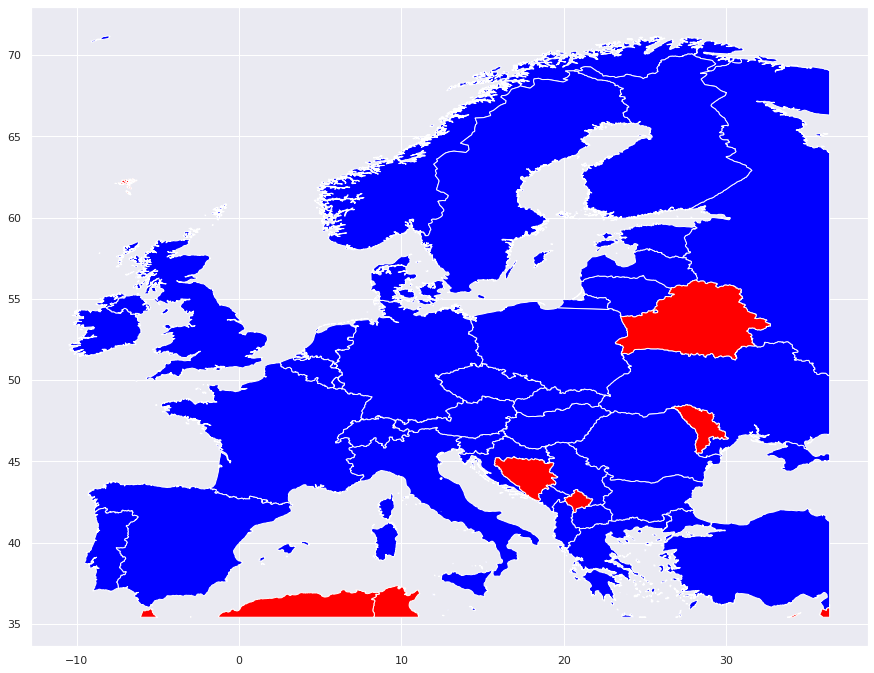

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
final_inters.plot(color='blue', ax=ax)
valid_inters.loc[[i for i in valid_inters.index if (i not in range(220, 224)) and (i not in final_inters.index)]].plot(color='red', ax=ax)

We now subdivide the region of interest into a **15x15 grid** with rectangular cells of equal size, spanning only a few degrees of lat/long each. These cells will become the labels in our classification problem: the model will try to predict the cell containing the location from which the image was taken.

Among the cells in the 15x15 grid, we keep only those which overlap with the countries we have selected for more than 15% of their surface area. The resulting 143 cells, with their labels, are plotted below.

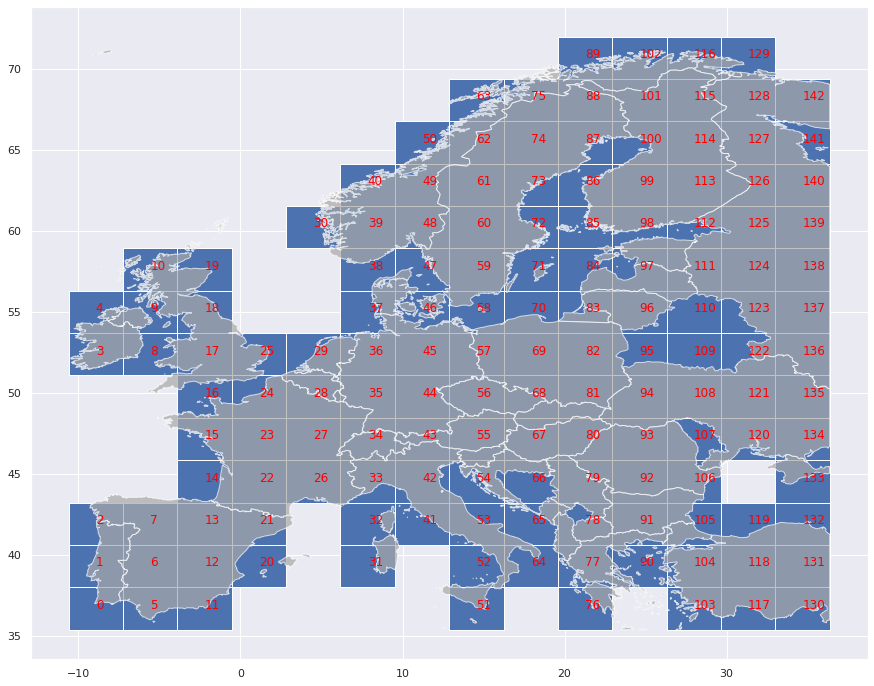

In [ ]:
#Grid size
grid_sz = 15

x_lin = np.linspace(long_min, long_max, grid_sz)
y_lin = np.linspace(lat_min, lat_max, grid_sz)
xx, yy = np.meshgrid(x_lin, y_lin)

#Grid of polygons
pol_grid = [Polygon([(xx[i][j], yy[i][j]), (xx[i+1][j], yy[i+1][j]),  (xx[i+1][j+1], yy[i+1][j+1]), (xx[i][j+1], yy[i][j+1])]) \
            for j in range(len(x_lin) - 1) for i in range(len(y_lin) - 1) ]

#Selected countries
countries_geom = [p for mul in final_inters['geometry'].values for p in mul]

df_rows = []
for cell in pol_grid:
  overlap = []
  for pol in countries_geom: 
    inters = cell.intersection(pol)
    if inters.is_empty:
      continue
    if isinstance(inters, MultiPolygon):
      for f in inters:
        overlap.append(f)
    else:
      overlap.append(inters)
  
  mpol = MultiPolygon(overlap)

  #Discard cells which overlap with selected countries for less than 15%
  if mpol.area / cell.area > 0.15:
    df_rows.append({'cell':cell, 'geometry':mpol})

final_grid = gpd.GeoDataFrame(df_rows)

fig, ax = plt.subplots(figsize=(15, 12))

gpd.GeoDataFrame(final_grid['cell'].rename('geometry')).plot(ax=ax)
final_inters['geometry'].plot(color='darkgray', ax=ax, alpha=0.7)
for i, cell in enumerate(final_grid.cell.values):
  ax.text(cell.centroid.x, cell.centroid.y, str(i), color='red', fontsize=12)

 A preliminary analysis shows that Google Street View coverage in cells number 128, 133, 142 is extremely limited, so we will drop them from our grid. We end up with 140 distinct labels.

In [ ]:
final_grid.drop([128, 133, 142], inplace=True)

## 2. Data scraping <a name=2></a>

It is now time to construct our dataset by fetching Street View images for all the grid cells. For each cell we will select **120 different locations** and then extract **3 different views from each location**. 

Data scraping is performed using the [Street View Static API](https://developers.google.com/maps/documentation/streetview/overview?hl=it). Utility classes and functions are provided in the ancillary `streetview_scraping_tools` module.

Within each cell of `final_grid` we first construct a regular grid of sampling locations, by using only the free [metadata](https://developers.google.com/maps/documentation/streetview/metadata?hl=it) API. If such grid does not provide enough data (because one or more locations have no Street View panoramas available in their neighbourhood) we sample random locations within the cell until we reach the desidered amount of images.  

The resulting list of panorama locations and the list of corresponding metadata id's are then added to `final_grid`.

In [ ]:
#Modify with your Google Maps Platform API key
api_key = '**REDACTED**'

sv = streetview_scraping_tools.StreetViewAPI(api_key=api_key)

final_grid[['grid_points', 'pano_ids']] = None
for id in final_grid.index:
  grid, panos = streetview_scraping_tools.sample_region(sv, final_grid.loc[id, 'geometry'], n_points=120)
  final_grid.at[id, 'grid_points'] = grid
  final_grid.at[id, 'pano_ids'] = panos

final_grid.head()

,cell,geometry,grid_points,pano_ids
0,"POLYGON ((-10.6 35.4, -10.6 38.01428571428571, -7.245714285714286 38.01428571428571, -7.245714285714286 35.4, -10.6 35.4))","(POLYGON ((-7.245714285714286 37.98619227684439, -7.245714285714286 37.20323417765203, -7.327870245999918 37.20156484600005, -7.343088344999956 37.19623444200005, -7.362904425999943 37.18170807500007, -7.381418423999946 37.17991771000004, -7.398508266999954 37.18545156500005, -7.414418097999942 37.19281647300005, -7.429386758999954 37.23674631800004, -7.434244343999865 37.259328919, -7.427578083999947 37.27452179000004, -7.437448282999952 37.30733632400005, -7.444993041999908 37.38676300100012, -7.462252970999884 37.41787221300008, -7.460030883999877 37.42913767500004, -7.462924763999865 3...","[POINT (-8.8070527 37.0733997), POINT (-8.024865200000001 37.0824952), POINT (-7.831037423670303 37.07964227491419), POINT (-8.608468999999999 37.1987791), POINT (-8.412896715346038 37.20106536474024), POINT (-8.218521274706829 37.19921365910869), POINT (-8.025215448214583 37.19806073420657), POINT (-7.8099769 37.2027751), POINT (-7.6285002 37.2038765), POINT (-7.440477374423117 37.1945316891676), POINT (-8.80372 37.3153238), POINT (-8.605521850324251 37.31142221819454), POINT (-8.410277522345771 37.30527935820151), POINT (-8.220762485125595 37.31556832487562), POINT (-8.0277669 37.3179504...","[UmKeOWHX5d7rMDcsVHveBg, qE3Ubess7fGoWTq8aotgYw, FvxXbplbzT2FONLty75QEw, KywOPGN1QGJjaOGUymJW9A, LGtL2eTWtbcUjORoUUbcuw, ikqmFzT-qDS9hpRtvGA_Wg, 5xj_uNPOFdqTkVjKdYkfnA, Hik8ZCAwaAWRJZARxapi-g, LQboW2Bk4byw3BShnUCsjA, -BbUYncB77c299bTfpIBKQ, QFia4c8TZ0tN7SH0cJDmfQ, BlvAhA_VoQg4MCwSWaPgbw, xZV3fgKl4fKuHAkTZXIZpQ, 5UGNzRt_EFPF8WZ59Sac8w, agUhyQ3qr0VBX72Nu1DtAw, FrhLaDY94zcLZTFpQXuMxg, 1xVwgJL3g4KwoQuWz2TLOQ, wg6hjxOcjP0teu7zGmYthw, DrgvBkdvZ9MrWnBcUg343g, 25iLeCs_XBiFHEkL4OICeg, 81ZkMq9zVMel2iMAabrgrA, AUm5yrBH9KcCFjqhLHj4cw, VFfZzPeR4sFv9IfWE45nXg, nooGe3Q9deAQ5M38Ec0-uA, mbyZuxUo4lZFbEd307w..."
1,"POLYGON ((-10.6 38.01428571428571, -10.6 40.62857142857143, -7.245714285714286 40.62857142857143, -7.245714285714286 38.01428571428571, -10.6 38.01428571428571))","(POLYGON ((-7.245714285714286 39.68408214151355, -7.245714285714286 39.19742640470943, -7.258079386999896 39.21130279500007, -7.265779174999892 39.23135325200009, -7.264332233999909 39.25233388300011, -7.250844685999937 39.27062734000008, -7.300454060999925 39.31791127500013, -7.319264282999939 39.32953847300008, -7.326654011999949 39.34132069900009, -7.331408243999931 39.36261139000005, -7.331925008999889 39.38472890200008, -7.326705688999937 39.39883656800002, -7.31885087099991 39.41325429300012, -7.313631550999901 39.43609527600005, -7.313528197999887 39.45743764300003, -7.3209179279998...","[POINT (-8.748141297459085 38.30699776372088), POINT (-8.498474950686393 38.30032943182083), POINT (-8.246611037633112 38.30564660655353), POINT (-7.990139385918505 38.30372774952835), POINT (-7.745445080993225 38.31253696729115), POINT (-7.489202670714952 38.31455666721268), POINT (-8.997806223375065 38.59507377387187), POINT (-8.747046014446065 38.59546954480279), POINT (-8.494551475660753 38.587068566127), POINT (-8.239909828650259 38.59270404989746), POINT (-7.998671628063558 38.58920281821205), POINT (-7.756661115517193 38.5793741732157), POINT (-7.495364722121507 38.59558193089977), ...","[baFLyNdrtd2TtkwjKwOnCw, s8m_q8syJ4z9xrwkFSxIHQ, RHFkcgO8FELAGqJ6AqHgVQ, liJZwIkMxXhdR6ppbsA2cg, 5GNw9z-yg46UwcDwO4h6Iw, rR1YzJ0CCyGVXWTCO8WJEw, n50HVHBHWdqrBIegvSEELg, 9odjDaw5FK5-2wWE0usyGA, k9lAMWV9p3asGPwpWV3weA, 6v4lcc3vbwy3akfvT78xdg, sT8K00olBUPb706Qpw8xVA, eOLB4YZGU-oog3T-GFpZuQ, 1TIK7eFGymXx3ozOy-830w, a7USlgu-YvSU_HD9-lTTFA, _wac2KNSCX4WOI7b_I3bmw, 1ju-MyTD-aQBUegdWI3vpQ, 8TgP9MY-2dxjHGKs9Iqucg, y5nyyNsjW_eTz04AYHPQlA, MIFFmbW9x8BM7mrXQaRtmA, bOp8zt6xsQ8yJksaMEG3zA, fV9pPRqI_dH38fwFMT_T5g, FLn33cUlTSpgSbgBhslsKw, uImRlf9U4KF6QzrO3yINkw, PAPj8UwjzrY0f9ZCNPY5ag, rdrLEGu7CFqmVV302ns..."
2,"POLYGON ((-10.6 40.62857142857143, -10.6 43.242857142857

As an example, let us take a look at the point grid generated within one of the cells in Italy.

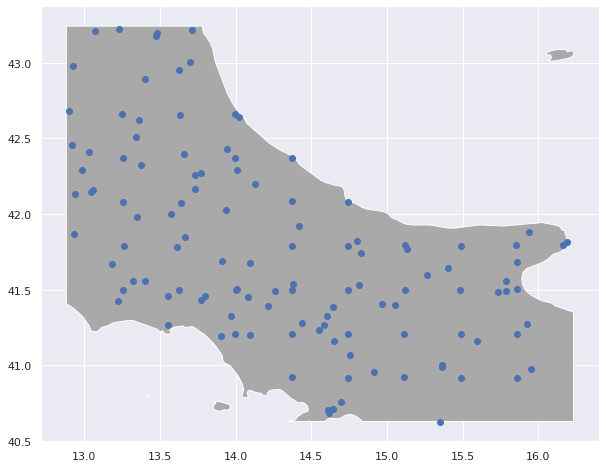

In [ ]:
cell_id = 53

fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoDataFrame(final_grid.loc[cell_id, 'geometry'], columns=['geometry']).plot(color='darkgray', ax=ax)
gpd.GeoDataFrame(final_grid.loc[cell_id, 'grid_points'], columns=['geometry']).plot(ax=ax)

We can now **retrieve images**: at each location we take three 640x640 px snapshots (with a 100° field of view) looking at different headings (0°, 120°, 240°). The images will be saved to local folders (labeled with the cell numbers) with relative paths of the form `europe_pictures_grid/n/country_n_i_t.jpg`, where `n` is the label of the cell, `i` is the number of the location (i.e. the index of the panorama in the corresponding list `final_grid.loc[n, 'pano_ids']`), `t = 0, 120, 240` gives the heading of the view and `country` is the country to which the location belongs.

In [ ]:
#Image size
sz = 640

#Number of views for each location
n_views = 3

def assign_mpol(point: Point, countries: List[MultiPolygon]) -> int:
  """
  Given a list of disjoint MultiPolygons and a point, determines the index of the MultiPolygon to which a point belongs.
  """
  for i, c in enumerate(countries):
    if point.within(c):
      return i


dir_path = Path("./europe_pictures_grid")
dir_path.mkdir(exist_ok=True)

for id in final_grid.index:
  print(f"Retrieving images for cell {id}")
  #Geometry of cell
  cell = final_grid.loc[id, 'cell']
  #Id's of countries intersecting the cell
  candidates_id = [country_id for country_id in final_inters.index if not cell.intersection(final_inters.loc[country_id, 'geometry']).is_empty]
  cell_dir = dir_path/str(id)
  cell_dir.mkdir(exist_ok=True)
  for j, pan_id in enumerate(final_grid.loc[id, 'pano_ids']):
    point = final_grid.loc[id, 'grid_points'][j]
    #Name of the country to which the point belongs (or "europe" if the assignment fails)
    try:
      country_name = final_inters.loc[candidates_id[assign_mpol(point, list(final_inters.loc[candidates_id, 'geometry'].values))], 'country']
    except:
      country_name = "europe"
    for v in range(n_views):
      heading = (360 // n_views) * v
      #Query image and save
      img = sv.query_image(pan_id, size=sz, heading=heading)
      img.save(cell_dir/f"{country_name}_{id}_{j}_{heading}.jpg")

Retrieving images for cell 0
Retrieving images for cell 1
Retrieving images for cell 2
Retrieving images for cell 3
Retrieving images for cell 4
Retrieving images for cell 5
Retrieving images for cell 6
Retrieving images for cell 7
Retrieving images for cell 8
Retrieving images for cell 9
Retrieving images for cell 10
Retrieving images for cell 11
Retrieving images for cell 12
Retrieving images for cell 13
Retrieving images for cell 14
Retrieving images for cell 15
Retrieving images for cell 16
Retrieving images for cell 17
Retrieving images for cell 18
Retrieving images for cell 19
Retrieving images for cell 20
Retrieving images for cell 21
Retrieving images for cell 22
Retrieving images for cell 23
Retrieving images for cell 24
Retrieving images for cell 25
Retrieving images for cell 26
Retrieving images for cell 27
Retrieving images for cell 28
Retrieving images for cell 29
Retrieving images for cell 30
Retrieving images for cell 31
Retrieving images for cell 32
Retrieving images fo

The resulting dataset contains 50400 (= 140 x 120 x 3) images. Let's look at a triplet.

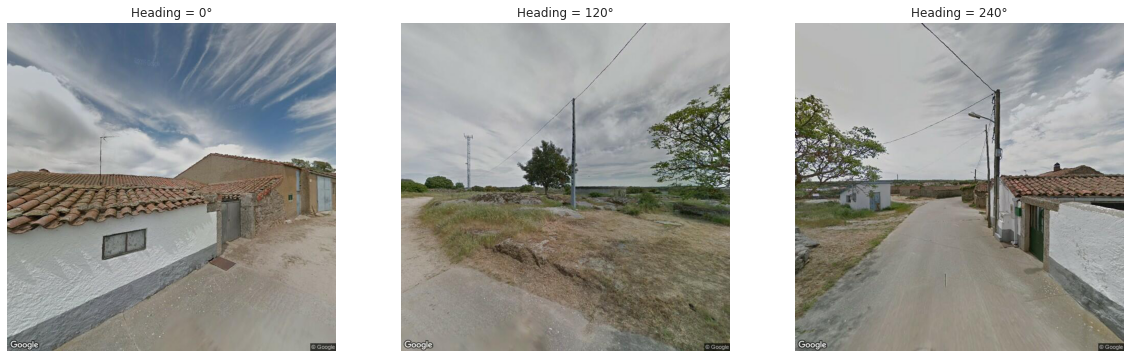

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 30))
for i, a in enumerate(ax):
  a.imshow(PILImage.create(Path(f'europe_pictures_grid/7/Spain_7_14_{120*i}.jpg')))
  a.set_title(f"Heading = {120*i}°")
  a.grid(None)
  a.axis('off')

## 3. Grid classification <a name=3></a>

We train a neural network which, given a picture, will predict the cell (in the 140-cells grid we defined above) containing the location where it was taken. Our baseline model will consider each image we scraped as a separate item, ignoring the triplet relationship for the time being.

We start by fixing a 90/10 train/validation split. When doing so, we want all three images coming from the same location to be in the same set, to avoid data leakage. So we perform the split not on the images, but on the locations (i.e. the points in `final_grid['grid_points']`).


In [ ]:
#Indices of validation images for each grid cell
n_locations = 120
val_idxs = pd.Series([RandomSplitter(valid_pct=0.1)(range(n_locations))[1] for _ in range_of(final_grid)], index=final_grid.index)
val_idxs

0           [102, 66, 10, 7, 30, 2, 40, 36, 78, 98, 88, 93]
1         [108, 83, 34, 92, 26, 85, 39, 32, 80, 27, 91, 72]
2           [90, 17, 61, 72, 47, 2, 116, 73, 3, 82, 42, 52]
3         [71, 5, 90, 48, 64, 30, 111, 12, 102, 95, 41, 40]
4           [56, 74, 40, 10, 95, 42, 3, 111, 60, 88, 8, 67]
                               ...                         
137        [56, 0, 44, 74, 40, 84, 106, 24, 111, 9, 91, 47]
138    [53, 82, 51, 99, 106, 20, 32, 92, 107, 102, 42, 105]
139    [115, 53, 114, 68, 111, 73, 18, 37, 74, 10, 59, 104]
140         [23, 104, 42, 82, 67, 75, 20, 0, 27, 35, 15, 3]
141     [25, 20, 88, 83, 52, 62, 14, 31, 75, 111, 119, 109]
Length: 140, dtype: object

We now build the dataloaders to feed the neural network, using FastAI. Each mini-batch contains 64 images, which we resize to 360x360 px after applying a mix of augmentation operations to increase signal (e.g. horizontal flips, rotations, perspective warping, change in brightness). Batches are then normalized using statistics from the ImageNet dataset.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


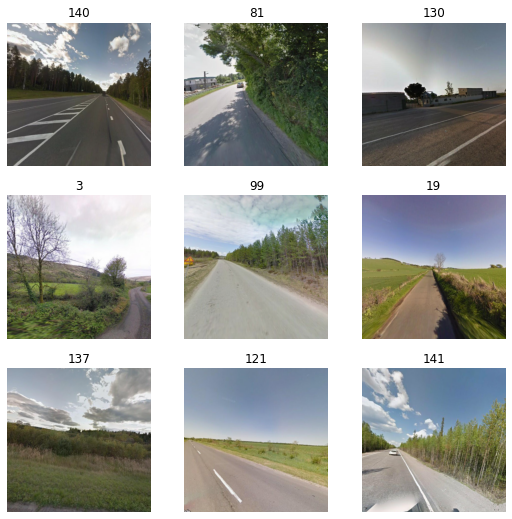

In [ ]:
def val_func(im_path: Path, val_idxs: list) -> bool:
  """ Determines whether an image is in the validation set"""
  match = re.match(r".+(\d+)_(\d+)_(\d+)$", im_path.stem).groups()
  lab = int(match[0])
  num_img = int(match[1])
  return num_img in val_idxs[lab]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, get_y=parent_label,
                   splitter=FuncSplitter(partial(val_func, val_idxs=val_idxs)),
                   batch_tfms=[*aug_transforms(size=360, min_scale=0.7), Normalize.from_stats(*imagenet_stats)])

dir_path = Path("./europe_pictures_grid")
dls = dblock.dataloaders(dir_path, bs=64)

dls.show_batch(max_n=9)

Since the number of images per class is not so large, we will use **transfer learning** starting from a pretrained 50-layer ResNet architecture, which we fine-tune. The loss function is standard cross entropy. As metrics we consider both top-1 and top-5 accuracy, since we can expect that several different cells share similar landscape features. For stepping parameters we use the Adam optimizer (`beta_1`=0.9, `beta_2`=0.99, `epsilon`=1e-5) and OneCycle training policy. We train for 15 epochs in total, but during the first two we freeze the encoder's parameters and train only the custom classification head.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.557388,3.966910,0.102183,0.312897,10:29
1,3.718545,3.473984,0.159127,0.435714,10:30


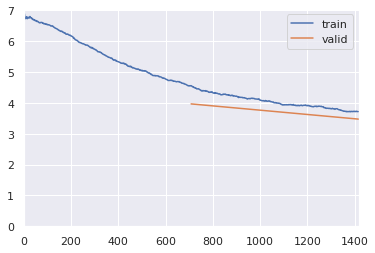

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.069407,3.026176,0.218254,0.541468,13:00
1,2.851305,2.877455,0.234722,0.578571,13:01
2,2.669989,2.858795,0.231746,0.582341,13:00
3,2.579862,2.800732,0.254960,0.606151,13:00
4,2.407888,2.700988,0.275595,0.632143,13:00
5,2.156066,2.671264,0.283135,0.650595,13:00
6,1.983585,2.722765,0.291071,0.649603,13:00
7,1.718277,2.740258,0.293056,0.652778,13:00
8,1.491134,2.720335,0.321627,0.678571,13:01
9,1.236224,2.706946,0.324802,0.695238,13:01


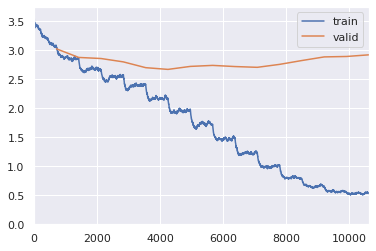

Epoch 3: reducing lr to 9.757419394820633e-05
Epoch 6: reducing lr to 8.666709827396679e-05
Epoch 8: reducing lr to 6.114703533191756e-05
Epoch 10: reducing lr to 3.1753300379198015e-05
Epoch 12: reducing lr to 8.700880799531657e-06
Epoch 14: reducing lr to 1.0044653831571201e-09


In [ ]:
resnet50_learn = cnn_learner(dls, resnet50, opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-5),
                     loss_func=CrossEntropyLossFlat(),  metrics=[accuracy, top_k_accuracy],
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), ShowGraphCallback()]).to_fp16()
                    
resnet50_learn.fine_tune(15, freeze_epochs=2)

Despite che low number of training elements per class, the model achieves respectable results: roughly **1-in-3 top-1 accuracy** and 2-in-3 top-5 accuracy.

To improve on this, we **aggregate the information coming from the three separate views** that we have for each location. This means that our model will make predictions on the location based not just on a single image, but on the whole set of views with different headings. Of course this increases the signal and we therefore expect a performance boost. 
Concretely, we use the same convolutional neural network (which is the one we trained before, without its classification head) to extract features from the single images. We then pass such features to a **concatenate layer** which feeds a custom classification head. The body of the resulting neural network will be kept frozen while we train the head. 

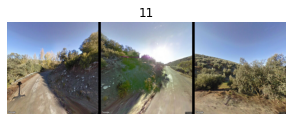

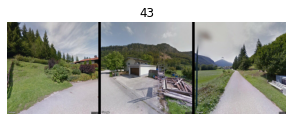

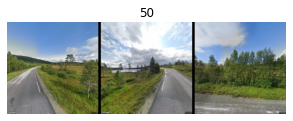

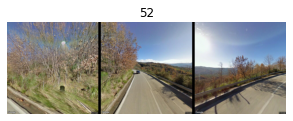

In [46]:
#Dataloaders

n_views = 3

def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

def get_geo_items(stems, n_views):
  """Returns the triplets of image paths and the corresponding label, given the location stems (n_views images per location)"""
  heads = [int(360/n_views)*i for i in range(n_views)]
  tuples = [[Path(str(stem) + f"_{h}.jpg") for h in heads] for stem in stems]
  for a in tuples:
    a.append(parent_label(a[0]))
  return tuples

def get_x_triple(t, n_views): return t[:n_views]
def get_y_triple(t, n_views): return t[n_views]

def val_func_triple(pt):
  """ Determines whether an item is in the validation set"""
  match = re.match(r".+(\d+)_(\d+)_(\d+)$", pt[0].stem).groups()
  lab = int(match[0])
  num_img = int(match[1])
  return num_img in val_idxs[lab]


dblock_triple = DataBlock(blocks=(ImageTupleBlock, CategoryBlock), get_items=partial(get_geo_items, n_views=n_views),
    get_x=partial(get_x_triple, n_views=n_views), get_y=partial(get_y_triple, n_views=n_views), splitter=FuncSplitter(val_func_triple),
    item_tfms=Resize(360), batch_tfms=[Normalize.from_stats(*imagenet_stats)])

imgs = get_image_files("./europe_pictures_grid")
unique_stems = list(set([im.parent/(re.match(r"(.+)_(\d+)$", im.stem).groups()[0]) for im in imgs]))

#Since each item is a tuple of images, reduce the batch size
dls_triple = dblock_triple.dataloaders(unique_stems, bs=32)

dls_triple.show_batch(max_n=4)

In [34]:
#Model

class geo_card_model(Module):
  """Architecture which applies the encoder to each inpute (with weight tying) and then passes the concatenated results to the head."""
  def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
  def forward(self, x):
      ftrs = torch.cat(list(map(self.encoder, x)), dim=1)
      return self.head(ftrs)

def geo_splitter(model):
  return [params(model.encoder), params(model.head)]


#As encoder we use the one from our single-image pretrained ResNet
encoder = create_body(lambda pretrained: resnet50_learn.model)

#Fastai custom classification head, with pooling and two dense layers (with dropout and batch normalization)
head = create_head(2048*n_views, dls_triple.c, ps=0.5)

head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(12288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=12288, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=140, bias=False)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0004786300996784121)

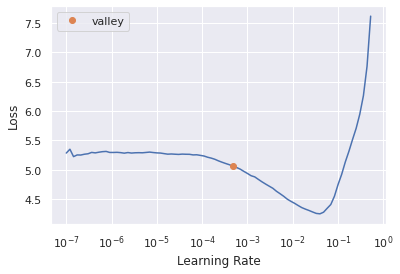

In [ ]:
model_triple = geo_card_model(encoder, head)

resnet50_learn_triple = Learner(dls_triple, model_triple, loss_func=CrossEntropyLossFlat(), splitter=geo_splitter, opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-5),  metrics=[accuracy, top_k_accuracy],
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), ShowGraphCallback()]).to_fp16()

resnet50_learn_triple.freeze()
resnet50_learn_triple.lr_find()


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.347490,2.397420,0.346429,0.721429,10:55
1,1.286765,2.995446,0.305357,0.664286,10:31
2,1.016916,3.071105,0.341667,0.691667,10:29
3,0.731399,3.134765,0.339881,0.700000,10:28
4,0.411321,3.229744,0.363690,0.703571,10:28
5,0.200381,3.248692,0.380952,0.721429,10:24
6,0.102491,3.173752,0.386310,0.727381,10:25
7,0.077875,3.179497,0.391071,0.721429,10:24


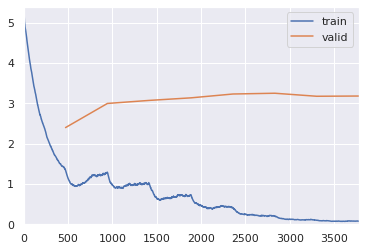

Epoch 2: reducing lr to 0.0001866580842164851
Epoch 4: reducing lr to 0.00010011192784974048
Epoch 6: reducing lr to 1.3454845981394902e-05


In [ ]:
resnet50_learn_triple.fit_one_cycle(8, lr_max=2e-3)

By pooling together the images for each location, **top-1 accuracy improves by a remarkable 20%**

In [50]:
#resnet50_learn.dls = dls
resnet50_learn_triple = load_learner("gdrive/MyDrive/Colab Notebooks/Geoguesser/triple_image_resnet50_8ep_freeze.pkl")
resnet50_learn_triple.dls = dls_triple

###3.1 Coordinates inference <a name=3.1></a>


One might be interested in predicting not only the grid cell, but the exact latitude/longitude coordinates of the location where the pictures were taken. A first approach to this problem, using the classifiers we constructed, is to simply predict the centroid of the `geometry` multipolygon inside the grid cell which the model considers most likely. The function `coordinates_tools.distance_check` computes the average error (measured in degrees of latitude/longitude) for images in the validation set. This is the error for the single-image model:

In [ ]:
distance_check(resnet50_learn, final_grid, all=False)

Validation RMSE: 5.6227


A possibly better approach is to use not just the maximum of the final neural network activations, but all of them. Indeed, the cross entropy loss function applies Softmax to the final activations, hence turning them into a posteriori probabilities for each of the 140 classes. We can use such probabilities as weights for the centroids of all the mainland multipolygons (stored in `final_grid['geometry']`) and then take the weighted average as coordinates prediction. 

In [ ]:
distance_check(resnet50_learn, final_grid, all=True)

Validation RMSE: 4.9852


We see that the validation error is indeed lower when using the weighted average of all centroids to make our prediction. The error further reduces with the 3-images model, which has better accuracy.

In [ ]:
distance_check(resnet50_learn_triple, final_grid, all=True)

Validation RMSE: 4.4731


We see that the weighted prediction using the 3-image model is the one giving the smallest test error.

The following widget allows the user to upload a landscape image and obtain the 3-image model prediction for the grid cell and the latitude/longitude coordinates of the location.

In [ ]:
n_views = 3

thumb_outp = widgets.Output()
map_outp = widgets.Output()
upload_btn = HBox([widgets.FileUpload(description=f"View at {int(360/n_views)*i}°") for i in range(n_views)])
response_class = widgets.Label()
response_coord = widgets.Label()

def click_script(change, learn):
    img_tuple = ImageTuple([PILImage.create(upload.data[-1]) for upload in upload_btn])
    thumb_outp.clear_output()
    with thumb_outp: 
      ToTensor()(Resize(300)(img_tuple)).show(figsize=(10,10))
    pred_lb, pred_idx, probs = learn.predict(img_tuple)
    coords = predict_coords(probs, final_grid, learn.dls.vocab)
    response_class.value = f'The model predicts cell {pred_lb}, with probability {probs[pred_idx]:.03f}. See the map below for the top 5 predictions (higher color intensity = higher probability).'
    response_coord.value = f'The model predicts lat/long coordinates: {coords[1]:.6f}, {coords[0]:.6f} (green dot on the map).'
    top5_weights, top5_labels = probs.topk(k=5)
    map_outp.clear_output()
    with map_outp:
      fig, ax = plt.subplots(figsize=(15, 12))
      gpd.GeoDataFrame(final_inters['geometry']).plot(color='darkgray', alpha=0.7, ax=ax)
      for j, id in enumerate(learn.dls.vocab[top5_labels]):
        cell = final_grid.loc[int(id), 'cell']
        gpd.GeoDataFrame({'geometry':[cell]}).plot(ax=ax, edgecolor=None, alpha=np.max([0.05, float(top5_weights[j])]))
        ax.text(cell.centroid.x, cell.centroid.y, id, color='red', fontsize=12)
      ax.plot([coords[0]], [coords[1]], marker='o', markersize=4, color='green')
      plt.show(fig)

cl_btn = widgets.Button(description='Predict')
cl_btn.on_click(partial(click_script, learn=resnet50_learn_triple))

VBox([widgets.Label('Upload landscape views at required headings, then click on "Predict" button.'), upload_btn, cl_btn, thumb_outp, response_class, response_coord, map_outp])

## 4. Country prediction <a name=4></a>


A parallel task is trying to predict the **country** where a picture was taken, instead of the specific geographical region.  

If we stick to the 39 countries contained in the `final_inters` dataframe, our current database of images is unbalanced for the new task (it contains an equal amount of images for each grid cell, therefore larger countries are over-represented). We can afford to aquire more data to reach balance, and to use a larger ratio of datapoints per class (since we now deal with significantly less labels). We will work with **450 locations** per country, and -- as before -- for each of them we download 3 views at different headings.

In [ ]:
images = get_image_files(dir_path)

#Discard locations where country assignment failed
for im in images:
  match = re.match(r"(.+)_(\d+)_(\d+)_(\d+)$", im.stem).group(1)
  if match == 'europe':
    im.unlink()
      
#Number of locations already available for each country
avail_locs_by_country_id = dict()
for id in final_inters.index:
  country = final_inters.loc[id, 'country']
  count = 0
  for im in images:
    if re.match(r"(.+)_(\d+)_(\d+)_(\d+)$", im.stem).group(1) == country:
      count += 1
  avail_locs_by_country_id[id] = count // n_views

#Dataframe of new points (and panorama ids) for country where we have an insufficient number of locations
new_points = pd.DataFrame({'new_grid': None, 'new_panos': None}, index = final_inters.index)

for id in final_inters.index:
  avail_locs = avail_locs_by_country_id[id]
  print(f"Country: {final_inters.loc[id, 'country']}; available locations: {avail_locs}")
  # If not enough locations already, randomly generate the missing ones
  if avail_locs < n_locs_per_country :
    grid, panos = sample_region(sv, final_inters.loc[id, 'geometry'], n_points =(n_locs_per_country  - avail_locs), only_rand=True)
    new_points.at[id, 'new_grid'] = grid
    new_points.at[id, 'new_panos'] = panos

Country: France; available locations: 1212
Country: Ukraine; available locations: 853
Country: Lithuania; available locations: 181
Country: Russia; available locations: 1439
Country: Czechia; available locations: 261
Country: Germany; available locations: 216
Country: Estonia; available locations: 157
Country: Latvia; available locations: 321
Country: Norway; available locations: 1415
Country: Sweden; available locations: 1364
Country: Finland; available locations: 1184
Country: Luxembourg; available locations: 6
Country: Belgium; available locations: 69
Country: Macedonia; available locations: 26
Country: Albania; available locations: 40
Country: Turkey; available locations: 989
Country: Spain; available locations: 980
Country: Denmark; available locations: 327
Country: Romania; available locations: 493
Country: Hungary; available locations: 157
Country: Slovakia; available locations: 75
Country: Poland; available locations: 845
Country: Ireland; available locations: 293
Country: Unit

In [ ]:
#Number of current images for each grid cell
curr_img = {cell_id:120 for cell_id in final_grid.index}

for id in final_inters.index:
  if not new_points.loc[id, 'new_grid']:
    continue
  country_name = final_inters.loc[id, 'country']
  print(f"Retrieving additional images for country {country_name}")
  #Geometry of country
  geo = final_inters.loc[id, 'geometry']
  #Id's of cells intersecting geo
  candidates_id = [cell_id for cell_id in final_grid.index if not final_grid.loc[cell_id, 'cell'].intersection(geo).is_empty]
  for j, pan_id in enumerate(new_points.loc[id, 'new_panos']):
    point = new_points.loc[id, 'new_grid'][j]
    #Id of cell to which the point belongs
    cell_id = candidates_id[assign_mpol(point, list(final_grid.loc[candidates_id, 'cell'].values))]
    cell_dir = dir_path/str(cell_id)
    cell_dir.mkdir(exist_ok=True)
    for v in range(n_views):
      heading = (360 // n_views) * v
      #Query image and save
      img = sv.query_image(pan_id, size=sz, heading=heading)
      img.save(dir_path/f"{cell_id}/{country_name}_{cell_id}_{curr_img[cell_id]}_{heading}.jpg")
    curr_img[cell_id] = curr_img[cell_id] + 1

Retrieving additional images for country Lithuania
Retrieving additional images for country Czechia
Retrieving additional images for country Germany
Retrieving additional images for country Estonia
Retrieving additional images for country Latvia
Retrieving additional images for country Luxembourg
Retrieving additional images for country Belgium
Retrieving additional images for country Macedonia
Retrieving additional images for country Albania
Retrieving additional images for country Denmark
Retrieving additional images for country Hungary
Retrieving additional images for country Slovakia
Retrieving additional images for country Ireland
Retrieving additional images for country Greece
Retrieving additional images for country Austria
Retrieving additional images for country Switzerland
Retrieving additional images for country Netherlands
Retrieving additional images for country Serbia
Retrieving additional images for country Croatia
Retrieving additional images for country Slovenia
Retrie

Now that we have downloaded images from at least 450 locations for each of the 39 countries we need to discard images in excess, so that our dataset is balanced. Again, when deciding which images to keep we need to make sure that we group together the 3 images corresponding to the same location (so we either keep all of them, or discard all of them). The same holds for splitting the images between the training and validation datasets.

In [ ]:
#Number of locations per country
n_locs = 450

#Dataframe of paths of all images
imgs_df = pd.DataFrame({'path':get_image_files(dir_path)})

#Extract from path the name of country
imgs_df['country'] = imgs_df.apply(lambda x: re.match(r"^(.+)_(\d+)_(\d+)_(\d+)", x.path.name).group(1), axis=1)
#Extract from path the location (discard view heading)
imgs_df['location'] = imgs_df.apply(lambda x: re.match(r"^(.+)_(\d+).jpg$", str(x.path)).group(1), axis=1)

#Randomly select n_locs locations per country
loc_to_keep = imgs_df[['country', 'location']].drop_duplicates().groupby('country').apply(lambda x: x.sample(n_locs)).reset_index(drop=True)
#Randomly slect n_locs / 10 locations per country for validation
loc_for_valid = loc_to_keep.groupby('country').apply(lambda x: x.sample(n_locs//10)).reset_index(drop=True)['location']
loc_to_keep = loc_to_keep['location'].unique()

imgs_df['to_keep'] = imgs_df.apply(lambda r: r['location'] in loc_to_keep, axis=1)
imgs_df['is_valid'] = imgs_df.apply(lambda r: r['location'] in loc_for_valid, axis=1)

imgs_df

,path,country,loc,to_keep,is_valid
0,europe_pictures_grid_enlarged/124/Russia_124_41_240.jpg,Russia,europe_pictures_grid_enlarged/124/Russia_124_41,False,False
1,europe_pictures_grid_enlarged/124/Russia_124_59_0.jpg,Russia,europe_pictures_grid_enlarged/124/Russia_124_59,True,False
2,europe_pictures_grid_enlarged/124/Russia_124_41_120.jpg,Russia,europe_pictures_grid_enlarged/124/Russia_124_41,False,False
3,europe_pictures_grid_enlarged/124/Russia_124_74_0.jpg,Russia,europe_pictures_grid_enlarged/124/Russia_124_74,True,False
4,europe_pictures_grid_enlarged/124/Russia_124_105_120.jpg,Russia,europe_pictures_grid_enlarged/124/Russia_124_105,True,False
...,...,...,...,...,...
74731,europe_pictures_grid_enlarged/1/Portugal_1_173_0.jpg,Portugal,europe_pictures_grid_enlarged/1/Portugal_1_173,True,True
74732,europe_pictures_grid_enlarged/1/Portugal_1_101_120.jpg,Portugal,europe_pictures_grid_enlarged/1/Portugal_1_101,True,False
74733,europe_pictures_grid_enlarged/1/Portugal_1_93_0.jpg,Portugal,europe_pictures_grid_enlarged/1/Portugal_1_93,True,False
74734,europe_pictures_grid_enlarged/1/Portugal_1_79_240.jpg,Portugal,europe_pictures_grid_enlarged/1/Portugal_1_79,True,False


We can now readily build the dataloaders, using the same batch transformations that we applied in the previous task...

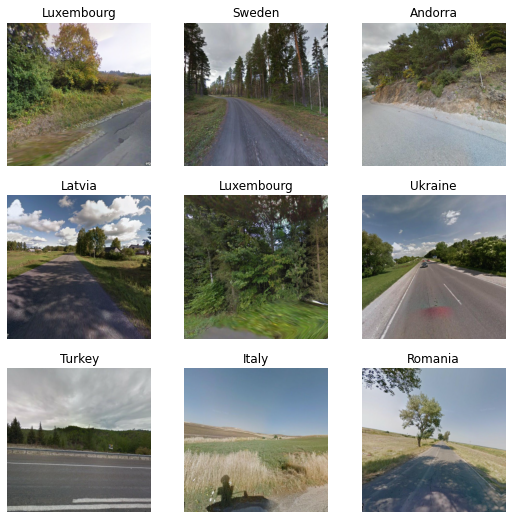

In [ ]:
def get_x(r):
  return r.path

def get_y(r):
  return r.country

dblock_country = DataBlock(blocks=(ImageBlock, CategoryBlock), get_x=get_x, get_y=get_y,
                   splitter=ColSplitter(), batch_tfms=[*aug_transforms(size=360, min_scale=0.7), Normalize.from_stats(*imagenet_stats)])

dls_country = dblock_country.dataloaders(imgs_df[imgs_df['to_keep']], bs=64)

dls_country.show_batch(max_n=9)

... and train a neural network with resnet50 architecture (here the metrics used are standard accuracy and **top-3** accuracy).

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.847019,2.312246,0.353656,0.592782,11:01
1,2.207723,1.959076,0.429060,0.665907,11:03


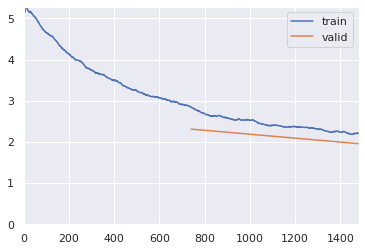

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.657492,1.529283,0.541500,0.771700,13:41
1,1.442909,1.393924,0.583096,0.803039,13:40
2,1.357378,1.447665,0.567521,0.796201,13:40
3,1.247981,1.286872,0.609117,0.826211,13:39
4,1.124075,1.309180,0.608927,0.826781,13:40
5,0.978418,1.273352,0.631909,0.843685,13:39
6,0.831238,1.234939,0.644634,0.847293,13:40
7,0.678655,1.222435,0.657740,0.854701,13:40
8,0.570678,1.222384,0.676733,0.861728,13:40
9,0.409445,1.243885,0.686990,0.864577,13:39


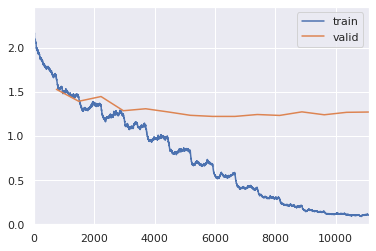

Epoch 5: reducing lr to 9.505726126912947e-05
Epoch 7: reducing lr to 7.501775633567263e-05
Epoch 9: reducing lr to 4.6284195173955955e-05
Epoch 11: reducing lr to 1.884213322607993e-05
Epoch 13: reducing lr to 2.2283020280245475e-06


In [ ]:
resnet50_learn_country = cnn_learner(dls_country, resnet50, opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-5),
                     loss_func=CrossEntropyLossFlat(),  metrics=[accuracy, partial(top_k_accuracy, k=3)],
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), ShowGraphCallback()]).to_fp16()
                    
resnet50_learn_country.fine_tune(15, freeze_epochs=2)

The results are very encouraging: **70% of top-1 accuracy** and almost 88% of top-3 accuracy!

As we did before for grid classification, we can improve on this single-image model by **concatenating the outputs** of the views at the same location.

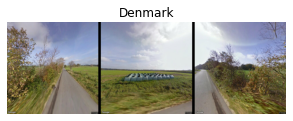

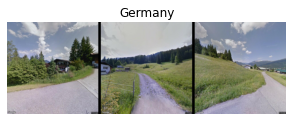

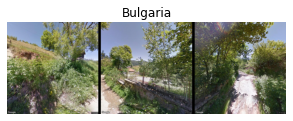

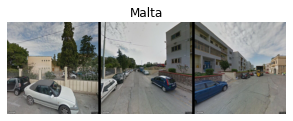

In [54]:
#Dataloaders

n_views = 3

def get_x3(row, n_views):
  heads = [int(360/n_views)*i for i in range(n_views)]
  return [Path(row['loc'] + f"_{h}.jpg") for h in heads]

def get_y3(row):
  return row.country

dblock_country3 = DataBlock(blocks=(ImageTupleBlock, CategoryBlock), get_x=partial(get_x3, n_views=n_views), get_y=get_y3,
    splitter=ColSplitter(), item_tfms=Resize(360), batch_tfms=[Normalize.from_stats(*imagenet_stats)])

df = imgs_df.loc[imgs_df['to_keep'], ['loc', 'country', 'is_valid']].drop_duplicates()

dls_country3 = dblock_country3.dataloaders(df, bs=32)

dls_country3.show_batch(max_n=4)

In [ ]:
#Model

encoder = create_body(lambda pretrained: resnet50_learn_country.model)

#Fastai custom classification head
head = create_head(2048*n_views, dls_country3.c, ps=0.5)

model_country3 = geo_card_model(encoder, head)

Let's train the head for a few epochs (we keep the pretrained encoder frozen).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0003981071640737355)

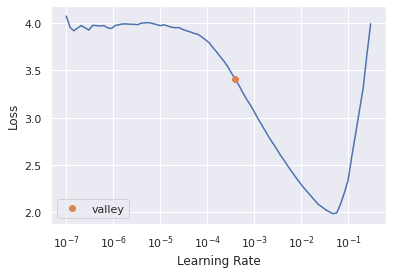

In [ ]:
learn_country3 = Learner(dls_country3, model_country3, loss_func=CrossEntropyLossFlat(), splitter=geo_splitter, opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-5), 
                         metrics=[accuracy, partial(top_k_accuracy, k=3)], cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), ShowGraphCallback()]).to_fp16()

learn_country3.freeze()
learn_country3.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.213495,1.024986,0.731054,0.880342,11:06
1,0.316571,1.257300,0.712821,0.880342,11:08
2,0.219371,1.198264,0.744160,0.894587,11:04
3,0.086480,1.170936,0.753846,0.905413,11:06
4,0.031420,1.079707,0.777778,0.919658,11:05
5,0.017002,1.065396,0.783476,0.919658,11:07


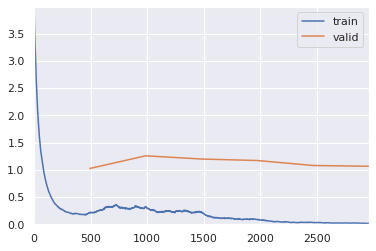

Epoch 2: reducing lr to 0.000150123092264915
Epoch 4: reducing lr to 2.348841434856282e-05


In [ ]:
learn_country3.fit_one_cycle(6, lr_max=2e-3, wd=0.0001)

The model based on integration brings the **top-1 accuracy up to over 78%, and top-3 accuracy over 91%**

Once again, here is the user-friendly widget for performing classification with this last model.

In [ ]:
n_views = 3

thumb_outp = widgets.Output()
map_outp = widgets.Output()
upload_btn = HBox([widgets.FileUpload(description=f"View at {int(360/n_views)*i}°") for i in range(n_views)])
response_class = widgets.Label()
response_coord = widgets.Label()

final_inters_by_name = final_inters.set_index('country')

cmap = plt.get_cmap('YlOrRd')
shades = [cmap(i) for i in range(1000)]

def click_script(change, learn):
    img_tuple = ImageTuple([PILImage.create(upload.data[-1]) for upload in upload_btn])
    thumb_outp.clear_output()
    with thumb_outp: 
      ToTensor()(Resize(300)(img_tuple)).show(figsize=(10,10))
    pred_lb, pred_idx, probs = learn.predict(img_tuple)
    response_class.value = f'The model predicts country {pred_lb}, with probability {probs[pred_idx]:.03f}. See the map below for probabilities (higher color intensity = higher probability).'
    map_outp.clear_output()
    with map_outp:
      fig, ax = plt.subplots(figsize=(15, 12))
      for country_id, pr in enumerate(probs):
        country = learn.dls.vocab[country_id]
        intensity = int(torch.floor((len(shades) - 1) * pr))
        gpd.GeoDataFrame({'geometry':[final_inters_by_name.loc[country, 'geometry']]}).plot(ax=ax, color=shades[intensity], edgecolor='darkgray')
      plt.show(fig)

cl_btn = widgets.Button(description='Predict')
cl_btn.on_click(partial(click_script, learn=learn3))

VBox([widgets.Label('Upload landscape views at required headings, then click on "Predict" button.'), upload_btn, cl_btn, thumb_outp, response_class, response_coord, map_outp])